# Predicting Heart Disease w/ Random Forest
- https://www.kaggle.com/ronitf/heart-disease-uci

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, auc, roc_curve, plot_roc_curve
import eli5
from eli5.sklearn import PermutationImportance
import pydot
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\uger7\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('heart.csv')

In [3]:
%matplotlib inline

In [4]:
def model_and_predict(clf):
    """trains the model and produces test-set and in-sample predictions"""
    clf.fit(X_train,y_train)
    pred = clf.predict_proba(X_test)[:,1]
    in_sample_pred = clf.predict_proba(X_train)[:,1]
    return pred, in_sample_pred

def get_fpr_tpr(pred,in_sample_pred):
    """uses predictions and in-sample predictions to produce true positive and false positive rates"""
    fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
    in_sample_fpr, in_sample_tpr, _ = roc_curve(y_train, in_sample_pred, pos_label=1)
    return fpr, tpr, in_sample_fpr, in_sample_tpr

## Split Data

In [5]:
X = data.drop(columns='target').values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=20,stratify=y)
EDAdata = pd.DataFrame(X_train,columns = data.columns[:-1])
EDAdata['target'] = y_train

## Exploratory Data Analysis

In [6]:
EDAdata.shape

(257, 14)

In [7]:
EDAdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,58.0,0.0,0.0,100.0,248.0,0.0,0.0,122.0,0.0,1.0,1.0,0.0,2.0,1
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1
2,62.0,0.0,0.0,140.0,268.0,0.0,0.0,160.0,0.0,3.6,0.0,2.0,2.0,0
3,66.0,1.0,0.0,160.0,228.0,0.0,0.0,138.0,0.0,2.3,2.0,0.0,1.0,1
4,57.0,1.0,0.0,110.0,335.0,0.0,1.0,143.0,1.0,3.0,1.0,1.0,3.0,0


In [8]:
EDAdata.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,54.182879,0.692607,0.972763,131.019455,244.906615,0.140078,0.533074,149.284047,0.334630,1.013619,1.400778,0.719844,2.287938,0.544747
std,9.043818,0.462314,1.028518,16.997116,48.238736,0.347745,0.522796,23.300874,0.472782,1.164216,0.624124,1.038006,0.620901,0.498965
min,29.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,274.000000,0.000000,1.000000,165.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,417.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


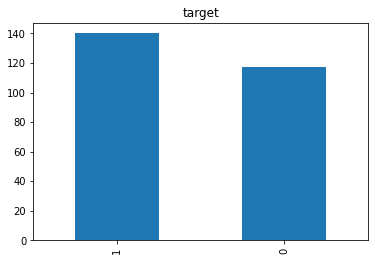

In [9]:
EDAdata.target.value_counts().plot.bar(title='target')
plt.show()

### continuous variables bivariate relationships with target

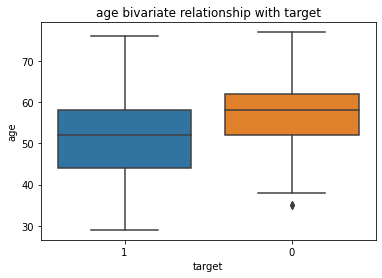

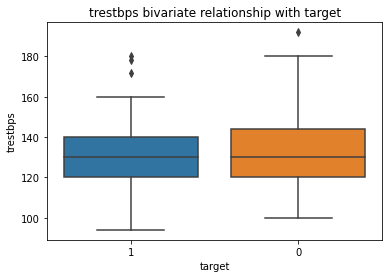

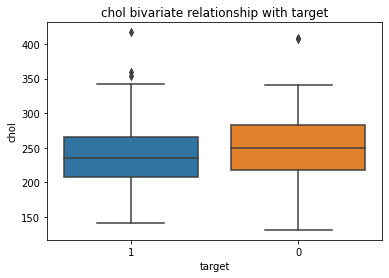

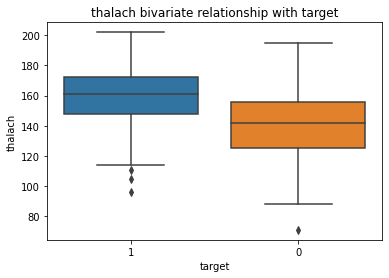

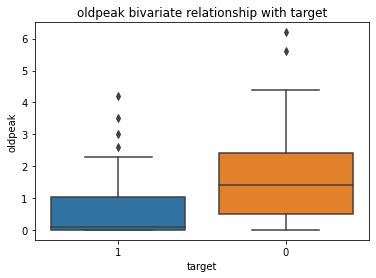

In [10]:
EDAdata['target'] = EDAdata['target'].astype(str)
continuous = ['age','trestbps','chol','thalach','oldpeak']
for c in continuous:
    ax = sns.boxplot(x="target",y=c,data=EDAdata)
    plt.title(f'{c} bivariate relationship with target')
    plt.show()

### categorical variables relationships

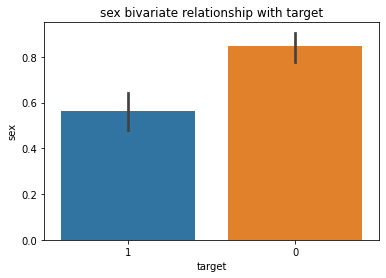

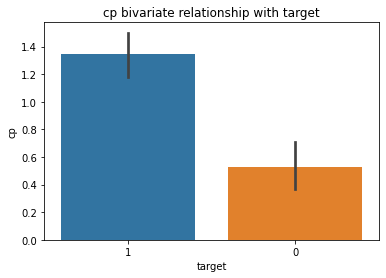

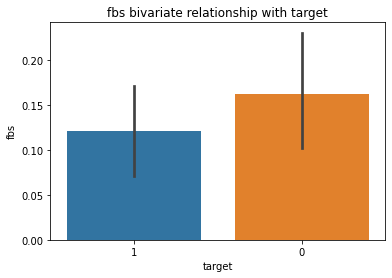

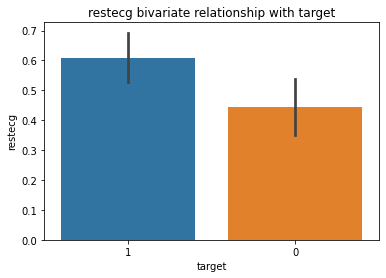

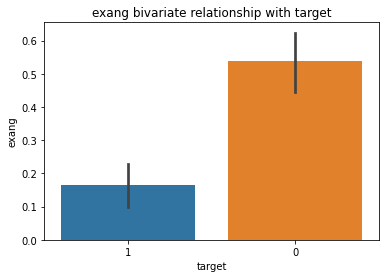

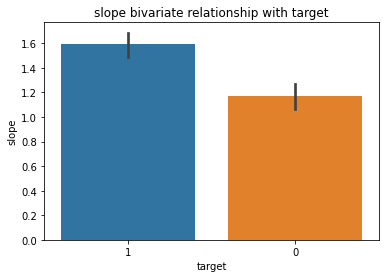

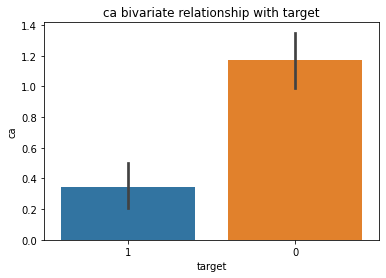

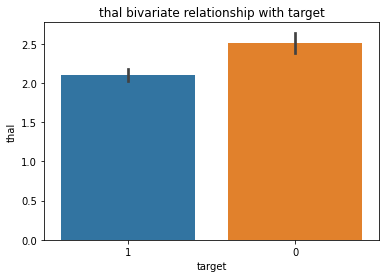

In [11]:
categorical = [c for c in data.columns if (c not in continuous) & (c != 'target')]
for c in categorical:
    ax = sns.barplot(x="target",y=c,data=EDAdata)
    plt.title(f'{c} bivariate relationship with target')
    plt.show()

## Decision Tree Classifier

In [12]:
plt.rcParams["figure.figsize"] = (10,6)

In [13]:
dt_clf = DecisionTreeClassifier(random_state=20)
dt_pred, dt_is_pred = model_and_predict(dt_clf)
dt_fpr, dt_tpr, dt_is_fpr, dt_is_tpr = get_fpr_tpr(dt_pred,dt_is_pred)

### f1 scores

In [14]:
print(f'decision tree out-of-sample f1 score: {f1_score(y_test,dt_pred)}')
print(f'decision tree in-sample f1 score: {f1_score(y_train,dt_is_pred)}')

decision tree out-of-sample f1 score: 0.6976744186046512
decision tree in-sample f1 score: 1.0


### auc

In [15]:
print(f'decision tree out-of-sample auc: {auc(dt_fpr,dt_tpr)}')
print(f'decision tree in-sample auc: {auc(dt_is_fpr,dt_is_tpr)}')

decision tree out-of-sample auc: 0.7285714285714286
decision tree in-sample auc: 1.0


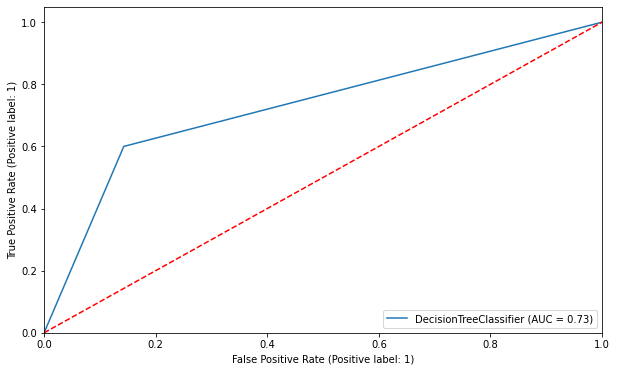

In [16]:
plot_roc_curve(dt_clf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## Out of Box Random Forest

In [17]:
rf_clf = RandomForestClassifier(random_state=20)
rf_pred, rf_is_pred = model_and_predict(rf_clf)
rf_fpr, rf_tpr, rf_is_fpr, rf_is_tpr = get_fpr_tpr(rf_pred,rf_is_pred)

### f1 scores

In [18]:
print(f'random forest out-of-sample f1 score: {f1_score(y_test,rf_pred.round())}')
print(f'random forest in-sample f1 score: {f1_score(y_train,rf_is_pred.round())}')

random forest out-of-sample f1 score: 0.8085106382978724
random forest in-sample f1 score: 1.0


### auc

In [19]:
print(f'random forest out-of-sample auc: {auc(rf_fpr,rf_tpr)}')
print(f'random forest in-sample auc: {auc(rf_is_fpr,rf_is_tpr)}')

random forest out-of-sample auc: 0.9038095238095237
random forest in-sample auc: 1.0


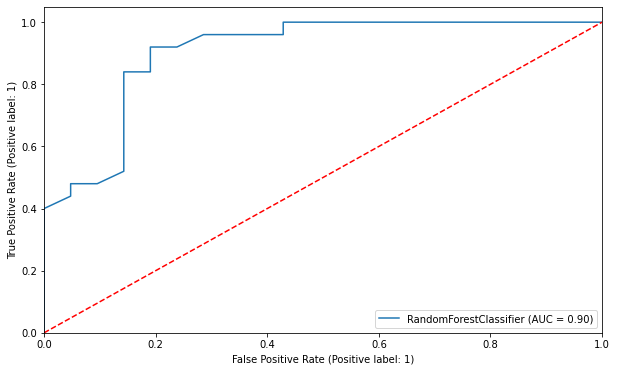

In [20]:
plot_roc_curve(rf_clf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## Parameter Tuning

### number of trees
- oob error

In [21]:
min_trees = 10
max_trees = 200
error_rate = {}
for i in range(min_trees,max_trees+1,10):
    clf = RandomForestClassifier(n_estimators=i,oob_score=True,random_state=20)
    clf.fit(X_train,y_train)
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error

C:\Users\uger7\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\uger7\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


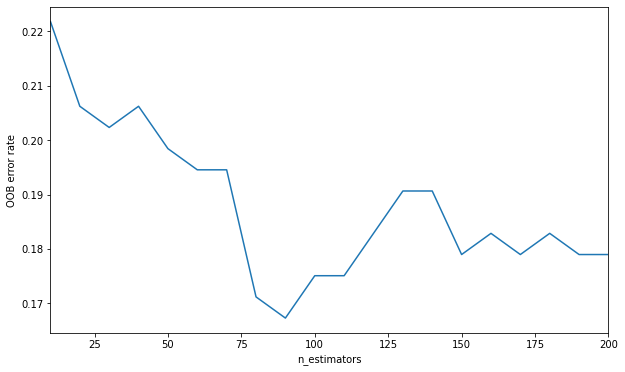

In [22]:
plt.plot(error_rate.keys(), error_rate.values())
plt.xlim(min_trees, max_trees)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

In [23]:
optimal_n_estimators = 90

### max depth and max features
- 10-folds cross validation

In [24]:
clf = RandomForestClassifier(n_estimators=optimal_n_estimators,oob_score=False,random_state=20)
parameters = {'max_depth':[2,3,4,5],'max_features':['sqrt',None],}
rf = GridSearchCV(clf, parameters, cv=10) # with larger datasets, this many folds could take a long time
rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=90, random_state=20),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_features': ['sqrt', None]})

In [25]:
print(f'best parameters: {rf.best_estimator_}')
print(f'highest cv accuracy: {rf.best_score_}')

best parameters: RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=90,
                       random_state=20)
highest cv accuracy: 0.8363076923076923


In [26]:
rf_tuned_pred = rf.predict_proba(X_test)[:,1]
rf_tuned_is_pred = rf.predict_proba(X_train)[:,1]
rf_tuned_fpr, rf_tuned_tpr, rf_tuned_is_fpr, rf_tuned_is_tpr = get_fpr_tpr(rf_tuned_pred,rf_tuned_is_pred)

### f1 scores

In [27]:
print(f'random forest out-of-sample f1 score: {f1_score(y_test,rf_tuned_pred.round())}')
print(f'random forest in-sample f1 score: {f1_score(y_train,rf_tuned_is_pred.round())}')

random forest out-of-sample f1 score: 0.88
random forest in-sample f1 score: 0.8881355932203391


### auc

In [28]:
print(f'random forest out-of-sample auc: {auc(rf_tuned_fpr,rf_tuned_tpr)}')
print(f'random forest in-sample auc: {auc(rf_tuned_is_fpr,rf_tuned_is_tpr)}')

random forest out-of-sample auc: 0.9333333333333333
random forest in-sample auc: 0.9357753357753358


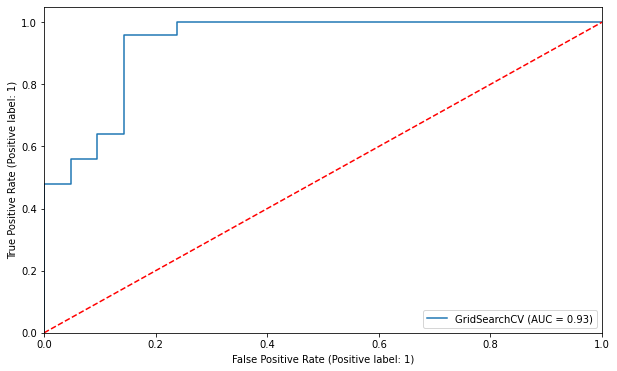

In [29]:
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## Feature Analysis

### Sklearn Feature Importance
- uses gini impurity on training set

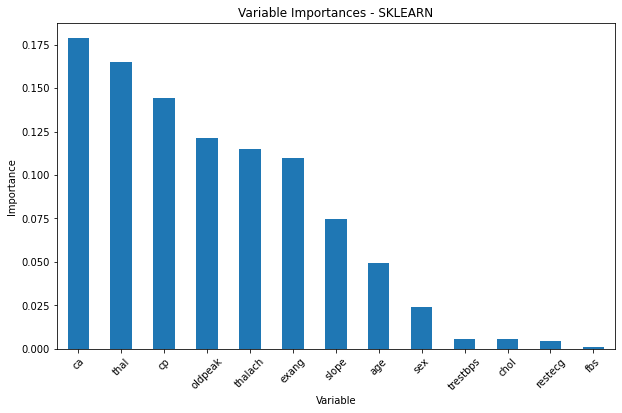

In [30]:
rf_final = RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=90, random_state=20)
rf_final.fit(X_train,y_train)
x_values = list(range(len(rf_final.feature_importances_)))
feature_df_skl = pd.DataFrame(rf_final.feature_importances_, index = data.columns.to_list()[:-1], columns = ['fi'])
feature_df_skl.sort_values('fi',ascending=False).plot.bar()
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.title('Variable Importances - SKLEARN')
plt.legend().remove()
plt.show()

### Eli5 Feature Importance
- uses permutation feature importance on test set

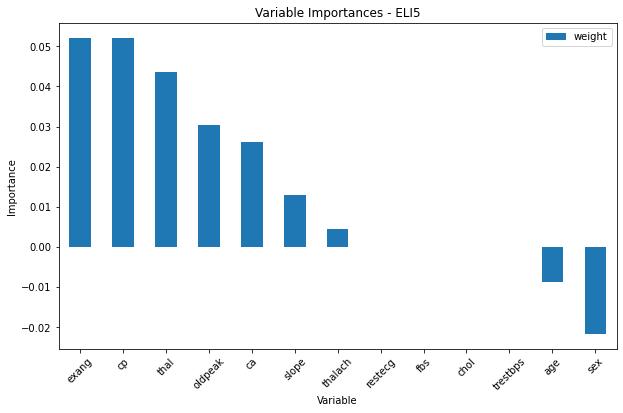

In [31]:
feats = PermutationImportance(rf_final).fit(X_test,y_test)
feature_df_eli5 = eli5.explain_weights_df(feats,feature_names=data.columns.to_list()[:-1]).set_index('feature')
feature_df_eli5.plot.bar(y='weight')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.title('Variable Importances - ELI5')
plt.show()

## Tree Diagrams

### Decision Tree

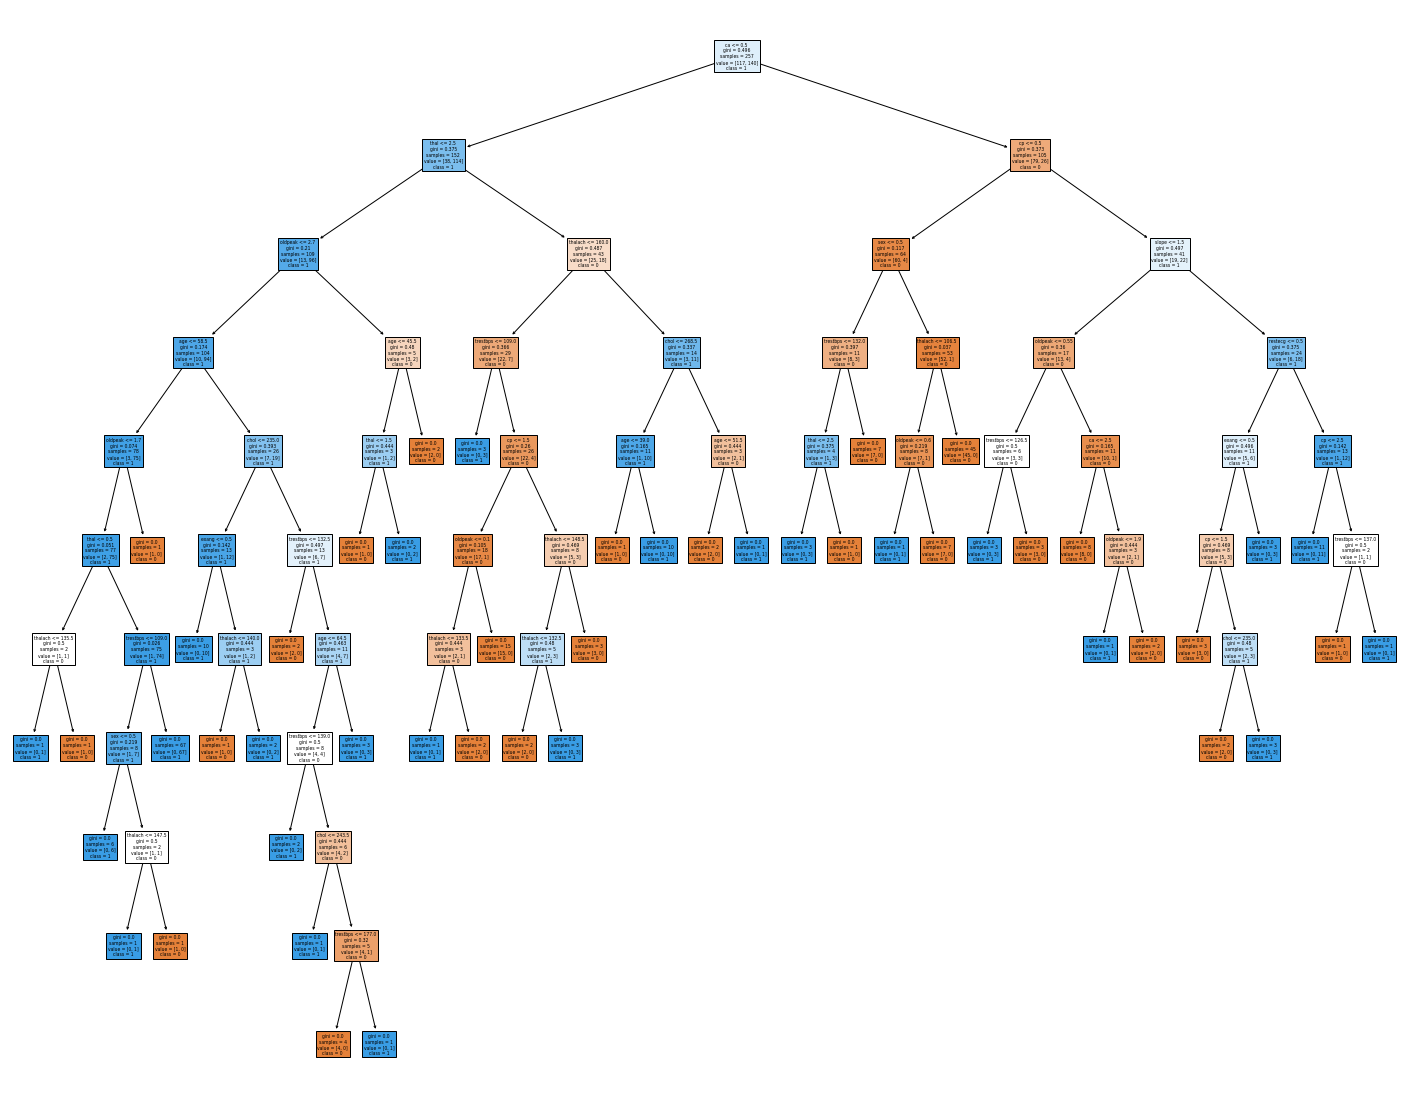

In [32]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_clf, 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()

### Random Forest

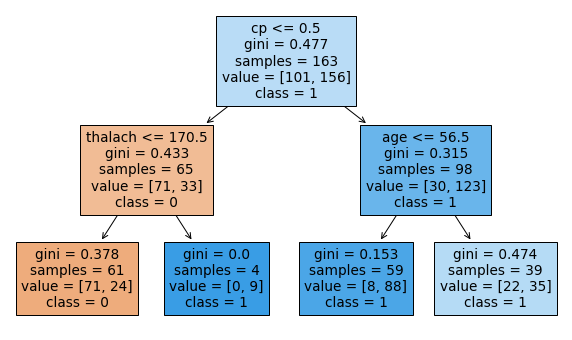

In [33]:
fig = plt.figure(figsize=(10,6))
_ = plot_tree(rf_final.estimators_[0], 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()

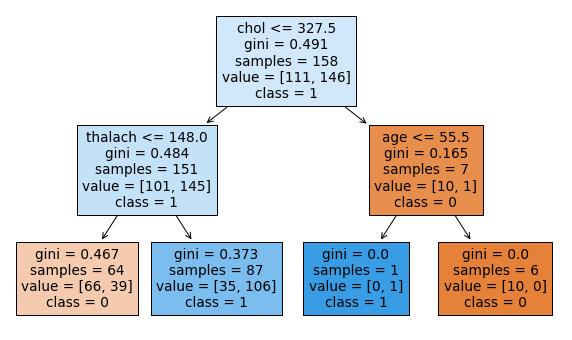

In [34]:
fig = plt.figure(figsize=(10,6))
_ = plot_tree(rf_final.estimators_[1], 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()

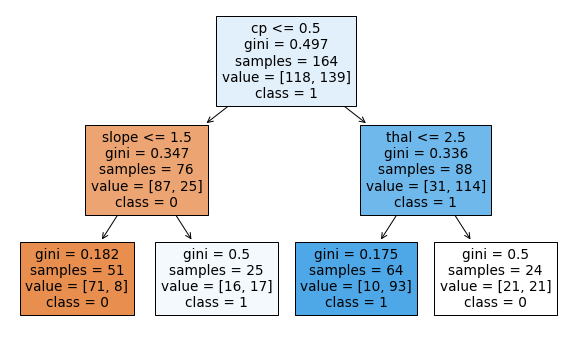

In [35]:
fig = plt.figure(figsize=(10,6))
_ = plot_tree(rf_final.estimators_[2], 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()

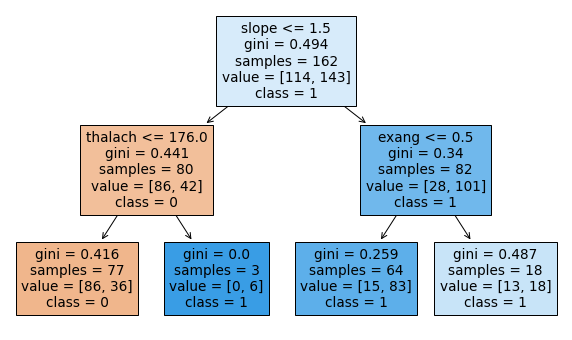

In [36]:
fig = plt.figure(figsize=(10,6))
_ = plot_tree(rf_final.estimators_[3], 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()

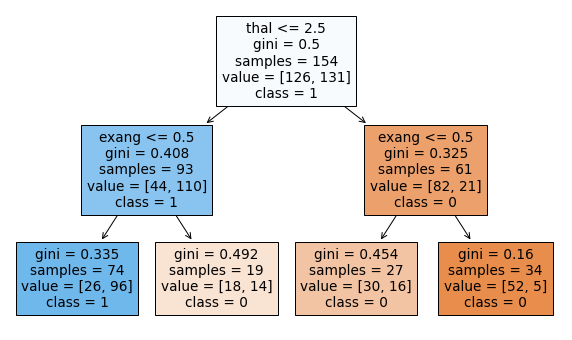

In [37]:
fig = plt.figure(figsize=(10,6))
_ = plot_tree(rf_final.estimators_[4], 
                   feature_names=data.columns.to_list()[:-1],  
                   class_names='01',
                   filled=True)
plt.show()